In [1]:
import pickle
import nltk
import  pandas as pd
from nltk.tokenize import word_tokenize
import nltk
import itertools
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go
import chart_studio
import chart_studio.plotly as py
import plotly.io as pio; pio.renderers.default='notebook'
import plotly.express as px

# nltk.download('averaged_perceptron_tagger')

import spacy

nlp = spacy.load("en_core_web_sm")





import sys
!{sys.executable} -m pip install chart_studio

In [2]:

set_mode = 'valid'
dialogs = pickle.load( open( "data/Persona-Chat/event/"+ set_mode+"_dict.pkl", "rb" ) )

df = pd.DataFrame.from_dict(dialogs)
df_event=df[["xEffect","xIntent","xNeed","xReact","xWant"]]


FileNotFoundError: [Errno 2] No such file or directory: 'data/Persona-Chat/event/valid_dict.pkl'

In [87]:
df['dialog_id'].describe()

count    23737.000000
mean       483.400008
std        279.257012
min          0.000000
25%        242.000000
50%        484.000000
75%        725.000000
max        967.000000
Name: dialog_id, dtype: float64

In [19]:
from tqdm import tqdm

import sys
from progress.bar import Bar


def analyze(attr):
    attr_list = list(df_event[attr].dropna())
    merged =[]
    cnt = 0
    for a in attr_list:
        if cnt % 2000 ==0:
            print(str(cnt)+'/'+str(len(attr_list)))
        for res in nlp(a):
            merged.append((res.text, res.tag_))
        cnt +=1
    print('======'+attr+'=======')
    print('total token',len(merged))
    
    nouns = list(filter(lambda x: x[1].startswith('N'), merged))

    print('total noun',len(nouns),'ratio',len(nouns)*1.0/len(merged))

    nouns = [x[0] for x in nouns]
    words = Counter(nouns)
    common = dict(words.most_common(10))
    
    matplotlib.rcParams.update({'font.size': 22})
    print(len(words))
    return words, common

In [16]:

# def analyze(attr):
#     attr_list = list(df_event[attr].dropna())
#     merged =[]
#     cnt = 0
#     for a in attr_list:
# #         if cnt % 10000 ==0:
# #             print(str(cnt)+'/'+str(len(attr_list)))
#         merged.extend(a.split())
#         cnt +=1
#     print('======'+attr+'=======')
#     print('total token',len(merged))

    
#     words = Counter(merged)
#     common = dict(words.most_common(10))
    
#     matplotlib.rcParams.update({'font.size': 22})
#     print('vocab size',len(words))
#     return words, common
# for att in ["xEffect","xIntent","xNeed","xReact","xWant"]:
#     analyze(att)

```python
Vocab statistic
TRAIN
======xEffect=======
total token 398845
vocab size 3386
======xIntent=======
total token 456535
vocab size 2684
======xNeed=======
total token 568924
vocab size 3808
======xReact=======
total token 132756
vocab size 549
======xWant=======
total token 498083
vocab size 2962

VALID
======xEffect=======
total token 47880
vocab size 1533
======xIntent=======
total token 54648
vocab size 1189
======xNeed=======
total token 67553
vocab size 1690
======xReact=======
total token 15735
vocab size 244
======xWant=======
total token 59800
vocab size 1275
```

# Cluster event

In [57]:
import pandas as pd

df = pd.read_csv('~/glove_dir/glove.6B.300d.txt', sep=" ", quoting=3, header=None, index_col=0)
glove = {key: val.values for key, val in df.T.items()}

In [5]:
import numpy as np
def sum_vec(x):
    res = np.zeros(300)
    words= x.split()
    for word in words:
        if word in glove:
            res+=glove[word]
    return res
    
import nltk
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
%matplotlib inline
def cluster(n_clusters,xs):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(xs)
    Z = kmeans.predict(xs)
    return kmeans, Z
def cluster_df(att,x=None,y=None):
    "Creates and TSNE model and plots it"
    if isinstance(att,list):
        
        res = df_event[att].dropna().agg(' '.join, axis=1).map(lambda x: sum_vec(x) ).tolist()
        labels = df_event[att].dropna().agg('-'.join, axis=1).tolist()
        tokens = res
    else:
        res = df_event[att].dropna().map(lambda x: sum_vec(x) )
        res = res.tolist()
        labels = df_event[att].dropna().tolist()
        tokens = res
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    print('train tsne')
    if x is None:
        new_values = tsne_model.fit_transform(tokens)
        x,y=zip(*new_values)
    
    print('cluster')
    model,Z = cluster(8,res)
    
    df = pd.DataFrame(list(zip(x,y,Z,labels)), 
                   columns =['x', 'y','cluster','event']) 
    return df,(x,y)

dfs= []
# for att in ["xEffect","xIntent","xNeed","xReact","xWant"]:
#     dfs.append(cluster_df(att))
res,p=cluster_df(["xEffect","xIntent","xNeed","xReact","xWant"],p[0],p[1])
dfs.append(res)

atts= ["xNeed"]#"xEffect","xIntent","xReact","xWant"]
for i,df in enumerate(dfs):
    fig = px.scatter(df, x="x", y="y", color="cluster",
             hover_data=['event'],title=atts[i])
    plotly.offline.plot(fig, filename = atts[i]+'.html')
# chart_studio.tools.set_credentials_file(username='cherie11', api_key='cz0kAdNA7UePDq0DJDCf')



train tsne
cluster


In [75]:
# import nltk
# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt
# from sklearn.cluster import KMeans
# %matplotlib inline
# def cluster(n_clusters,xs):
#     kmeans = KMeans(n_clusters=n_clusters)
#     kmeans.fit(xs)
#     return kmeans
# att="xNeed"#,"xIntent","xNeed","xReact","xWant"]
# res = df_event[att].dropna().map(lambda x: sum_vec(x) )
# res = res.tolist()
# labels = df_event[att].dropna().tolist()
# model = cluster(25,res)

def predict(att,df):
    if df[att] is None:
        return -1
    vec = sum_vec(df[att]).reshape(1,-1)
    pred = model.predict(vec)
    return pred[0]
df['cluster']= df.apply(lambda x :predict(att,x),axis =1)
# df.to_csv("data/Persona-Chat/event/"+ set_mode+".csv")

In [104]:
path= 'data/FSM/'
line = []
att=["xEffect","xIntent","xNeed","xReact","xWant"]
df['cluster']=df[att].dropna().agg(' <sep> '.join, axis=1)
with open(path+set_mode+'.txt','w') as f: 
    for idx in df['cluster'].tolist():
        if type(idx)==float:
            f.write('<sep>'+'\n')
        else:
            f.write(idx+'\n')

In [105]:
df.shape


(211803, 9)

In [102]:
df['cluster']

0                                                      NaN
1                                                      NaN
2                                                      NaN
3                                                      NaN
4                                                      NaN
                               ...                        
23732    gets exercise <sep> to have fun <sep> to go to...
23733    gets tired <sep> to be active <sep> to be acti...
23734    gets cold <sep> to have fun <sep> to buy a pla...
23735    shivers <sep> to enjoy the outdoors <sep> to g...
23736    gets a lot of attention <sep> to be noticed <s...
Name: cluster, Length: 23737, dtype: object

In [84]:
path= 'data/FSM/'
line = []
with open(path+set_mode+'_xneed.txt','w') as f: 
    for idx in df['xNeed'].tolist():
        if idx == None:
            f.write('<sep>'+'\n')
        else:
            f.write(idx+'\n')
          

In [12]:
att=["xEffect","xIntent","xNeed","xReact","xWant"]
res = df_event[att].dropna().agg(' '.join, axis=1).map(lambda x: sum_vec(x) )
res = res.tolist()
model,Z = cluster(10,res)
file="cluster_embed_all.npy"
np.save(file, model.cluster_centers_)

def predict(att,df):
    if df[att[0]] is None:
        return None
    vec = sum_vec(" ".join(df[att].tolist())).reshape(1,-1)
    pred = model.predict(vec)
    return pred[0]
df['cluster']= df.apply(lambda x :predict(att,x),axis =1)
df.to_csv("data/Persona-Chat/event/"+ set_mode+"_all.csv")

AttributeError: 'Series' object has no attribute 'split'

In [ ]:
df.shape

In [51]:
# import pickle
# s=pickle.dumps(model) 
# with open('cluster.joblib','wb') as f:
#     f.write(s)

# Plot Common words

0/15602
2000/15602
4000/15602
6000/15602
8000/15602
10000/15602
12000/15602
14000/15602
======xEffect=======
total token 47880
total noun 13758 ratio 0.28734335839598996


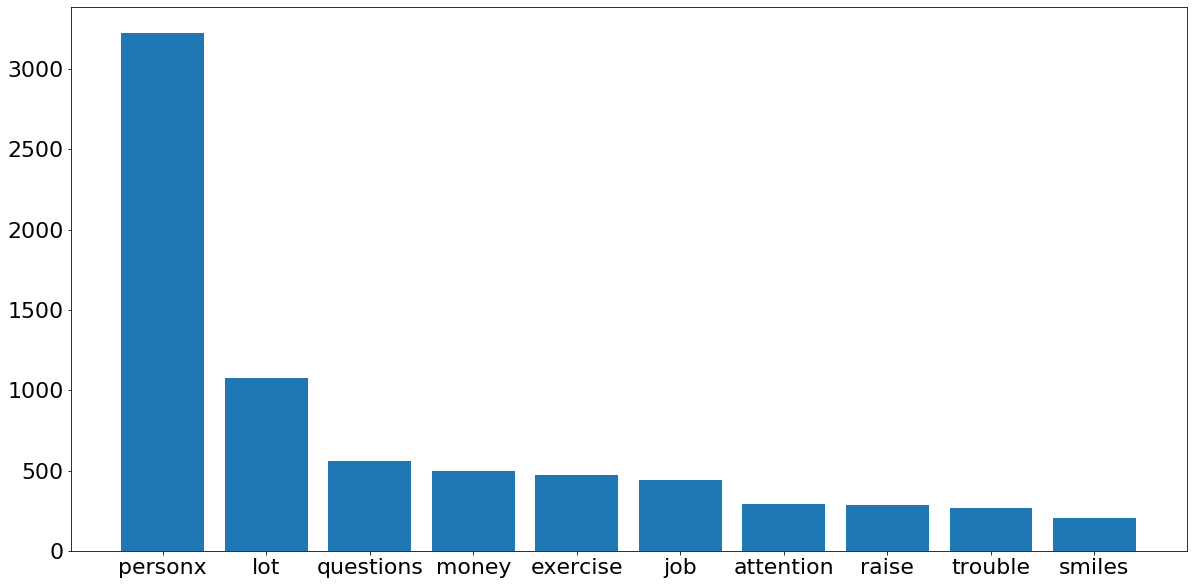

0/15602
2000/15602
4000/15602
6000/15602
8000/15602
10000/15602
12000/15602
14000/15602
======xIntent=======
total token 54648
total noun 8557 ratio 0.15658395549699897


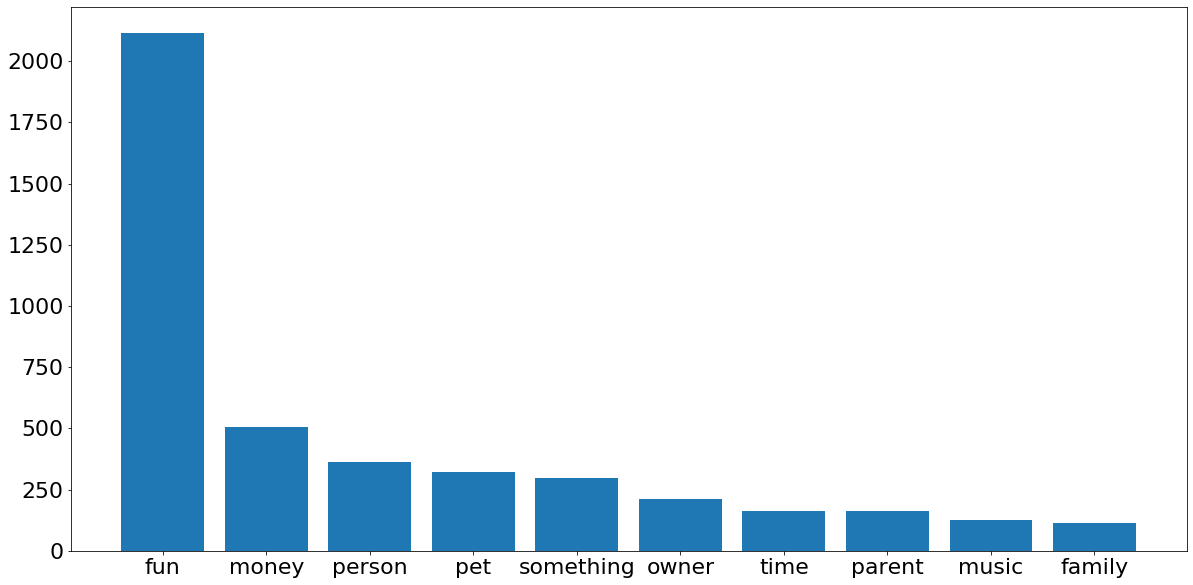

0/15602
2000/15602
4000/15602
6000/15602
8000/15602
10000/15602
12000/15602
14000/15602
======xNeed=======
total token 67553
total noun 15101 ratio 0.22354299586990956


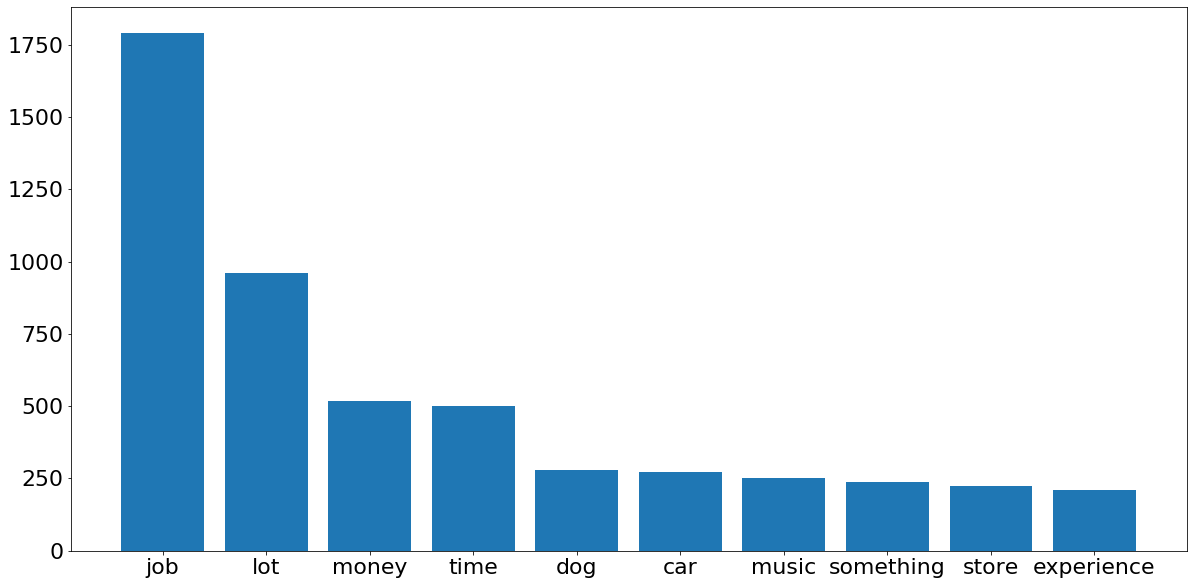

0/15602
2000/15602
4000/15602
6000/15602
8000/15602
10000/15602
12000/15602
14000/15602
======xReact=======
total token 15735
total noun 380 ratio 0.024149984111852558


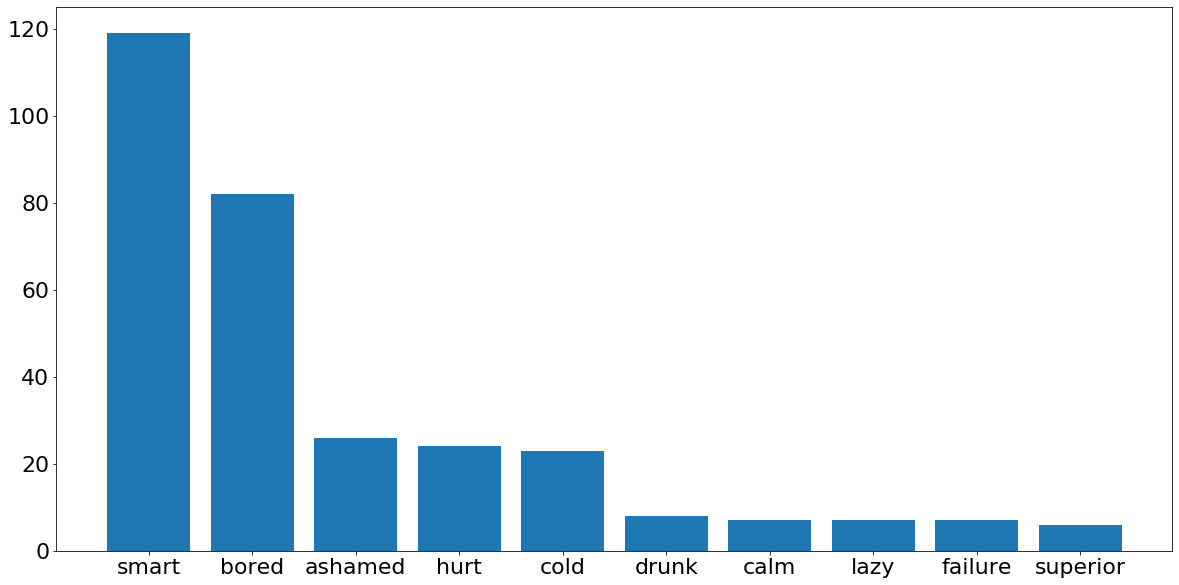

0/15602
2000/15602
4000/15602
6000/15602
8000/15602
10000/15602
12000/15602
14000/15602
======xWant=======
total token 59801
total noun 10748 ratio 0.17972943596260932


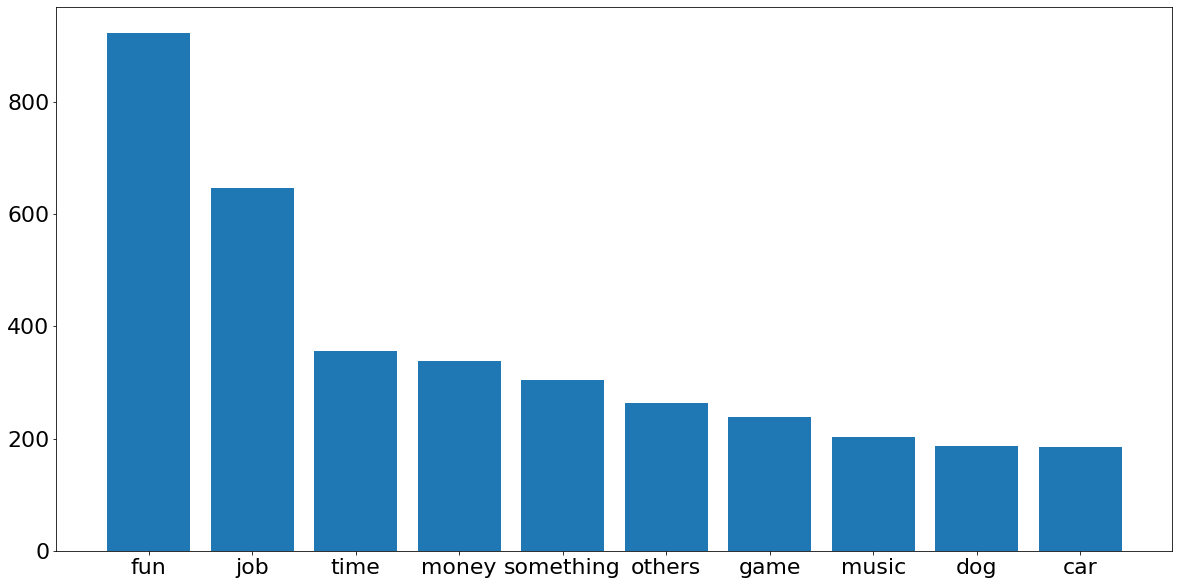

In [23]:
res_dict = {}
for att in ["xEffect","xIntent","xNeed","xReact","xWant"]:
    res, common = analyze(att)
    res_dict[att] = res
    plt.figure(figsize=(20,10))
    plt.bar(common.keys(), common.values())
    plt.show()

0/15024
2000/15024
4000/15024
6000/15024
8000/15024
10000/15024
12000/15024
14000/15024
======xIntent=======
total token 52842
total noun 8281 ratio 0.15671246357064456


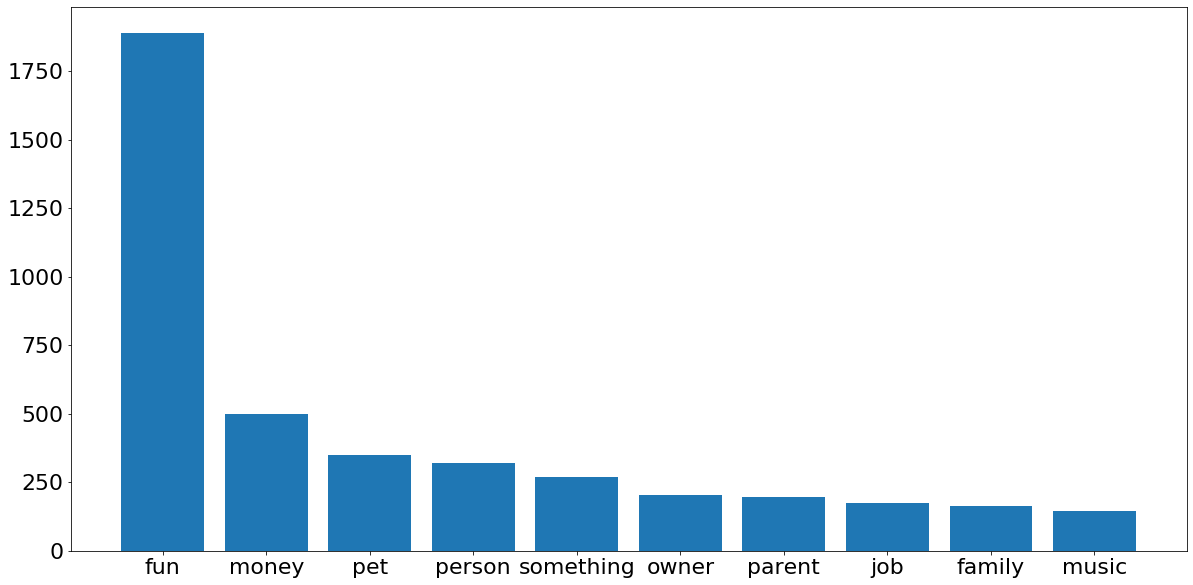

0/15024
2000/15024
4000/15024
6000/15024
8000/15024
10000/15024
12000/15024
14000/15024
======xNeed=======
total token 64769
total noun 14625 ratio 0.22580246722969322


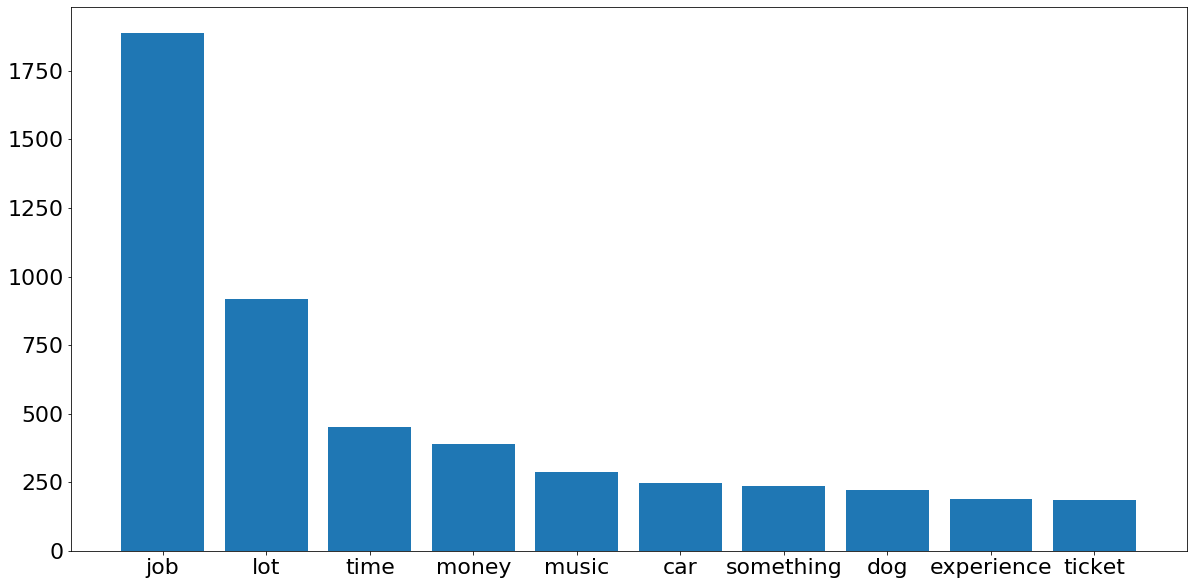

0/15024
2000/15024
4000/15024
6000/15024
8000/15024
10000/15024
12000/15024
14000/15024
======xReact=======
total token 15153
total noun 335 ratio 0.022107833432323632


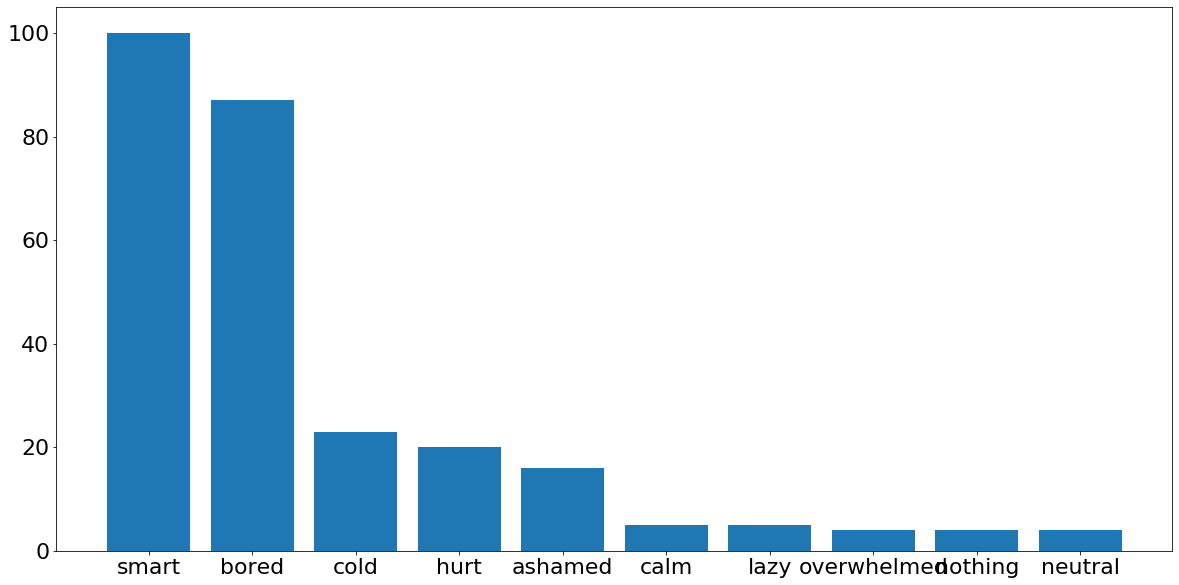

0/15024
2000/15024
4000/15024
6000/15024
8000/15024
10000/15024
12000/15024
14000/15024
======xWant=======
total token 57372
total noun 10289 ratio 0.17933835320365335


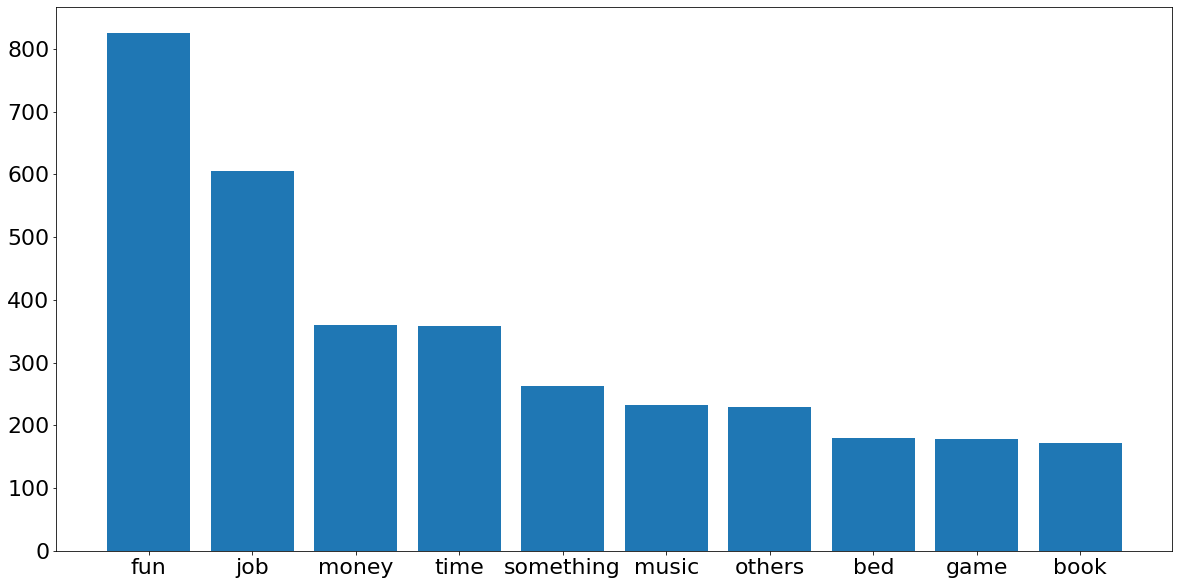

In [26]:
res_dict_te = {}
for att in ["xEffect","xIntent","xNeed","xReact","xWant"]:
    res, common = analyze(att)
    res_dict[att] = res
    plt.figure(figsize=(20,10))
    plt.bar(common.keys(), common.values())
    plt.show()

# Preprocess for seq2seq data

In [48]:
import pandas as pd

event_list = ['xEffect', 'xIntent', 'xReact','xNeed', 'xWant']
[ '<{}> '.format(e)for e in event_list] 

['<xEffect> ', '<xIntent> ', '<xReact> ', '<xNeed> ', '<xWant> ']

## Load Csv file with all cluster embedding

In [41]:
import pickle
from collections import deque

set_name='train'
df=pd.read_csv("data/Persona-Chat/event/"+ set_name+"_all.csv")
cluster=list(df.cluster)
print(len(cluster))


import pickle
from collections import deque
import os
dialogs = pickle.load( open( 'data/Persona-Chat/event/'+set_name+'_dict.pkl', "rb" ) )
print(len(dialogs))
def gen(attr):
    dialog_id = 0
    history =[]
    truncate_length = 3 
    add_event = True
    path ='data/KGdial/cluster_'+attr+'/'
    if not os.path.exists(path):
        os.makedirs(path)

    last_event = []
    his = deque([])
    cnt = 0
    sent_id=-1
    print('length',len(dialogs))
    with open(path + 'src-'+set_name+'.txt','w') as f_src:
            with open(path +'tgt-'+set_name+'.txt','w') as f_tgt:
                for utt in dialogs:
                    # First skip the persona
                    cnt +=1
                    sent_id+=1
                    
                    if utt['idx'] == -1:
                        continue
                    if utt['dialog_id'] == dialog_id:
                        if len(his)== 0:
                            his.append(utt["utterance"])  
                            continue
                        if add_event is True:
                            cur_events =  '<{}> '.format(attr)+'cluall'+str(int(cluster[sent_id]))
                        if len(his) > truncate_length:
                            his.popleft()
                        src_sent = " ".join(his)
                        if add_event is True:
                            src_sent += " "
                            src_sent += cur_events
                        f_src.write(src_sent+'\n')
    #                     assert utt["utterance"] ==dialog2[cnt-1]["utterance"]
                        f_tgt.write(utt["utterance"]+'\n')
                        his.append(utt["utterance"])

                    else:
                        his = deque([])
                        dialog_id += 1
                
                
event_list = ['all']
for e in event_list :
    gen(e)

211803
211803
length 211803


## Load Csv file with XNeed cluster embedding

In [57]:
import pickle
from collections import deque

set_name='test'
df=pd.read_csv("data/Persona-Chat/event/"+ set_name+".csv")
cluster=list(df.cluster)
print(len(cluster))


import pickle
from collections import deque
import os
dialogs = pickle.load( open( 'data/Persona-Chat/event/'+set_name+'_dict.pkl', "rb" ) )
print(len(dialogs))
def gen(attr):
    dialog_id = 0
    history =[]
    truncate_length = 3 
    add_event = True
    path ='data/KGdial/cluster_'+attr+'/'
    if not os.path.exists(path):
        os.makedirs(path)

    last_event = []
    his = deque([])
    cnt = 0
    sent_id=-1
    print('length',len(dialogs))
    with open(path + 'src-'+set_name+'.txt','w') as f_src:
            with open(path +'tgt-'+set_name+'.txt','w') as f_tgt:
                for utt in dialogs:
                    # First skip the persona
                    cnt +=1
                    sent_id+=1
                    
                    if utt['idx'] == -1:
                        continue
                    if utt['dialog_id'] == dialog_id:
                        if len(his)== 0:
                            his.append(utt["utterance"])  
                            continue
                        if add_event is True:
                            cur_events =  '<{}> '.format(attr)+'cl'+str(int(cluster[sent_id]))
                        if len(his) > truncate_length:
                            his.popleft()
                        src_sent = " ".join(his)
                        if add_event is True:
                            src_sent += " "
                            src_sent += cur_events
                        f_src.write(src_sent+'\n')
    #                     assert utt["utterance"] ==dialog2[cnt-1]["utterance"]
                        f_tgt.write(utt["utterance"]+'\n')
                        his.append(utt["utterance"])

                    else:
                        his = deque([])
                        dialog_id += 1
                
                
event_list = ['xNeed']
for e in event_list :
    gen(e)

23737
23737
length 23737


In [ ]:
import pickle
from collections import Counter

set_name='train'
df=pd.read_csv("data/Persona-Chat/event/"+ set_name+".csv")
cluster=list(df.cluster)
c = Counter(cluster)

In [37]:
# Add cluster embedding to Glove embedding
embeds=[]
cluster_rep=np.load("cluster_embed.npy")
for i in range(10):
    assert cluster_rep[i].shape == (300,)
    np.set_printoptions(suppress=True)
    rep="cluall{} ".format(i)+" ".join(map(str,cluster_rep[i].tolist()))
    embeds.append(rep)
with open("/home/xuewei/glove_dir/extra.txt",'w') as f:
    f.write("\n".join(embeds))
    f.write("\n")

In [55]:
cluster_rep.shape

(25, 300)

## Load csv data for cluster prediction

In [ ]:
import pickle
from collections import deque

set_name='test'
df=pd.read_csv("data/Persona-Chat/event/"+ set_name+".csv")
cluster=list(df.cluster)
print(len(cluster))


import pickle
from collections import deque
import os
dialogs = pickle.load( open( 'data/Persona-Chat/event/'+set_name+'_dict.pkl', "rb" ) )
print(len(dialogs))
def gen(attr):
    dialog_id = 0
    history =[]
    truncate_length = 10
    add_event = True
    path ='data/KGdial/cluster_pred_'+attr+'_event/'
    if not os.path.exists(path):
        os.makedirs(path)

    last_event = []
    his = deque([])
    cnt = 0
    sent_id=-1
    print('length',len(dialogs))
    with open(path + set_name+'.input','w') as f_src:
            with open(path+set_name+'.label','w') as f_tgt:
                for utt in dialogs:
                    # First skip the persona
                    cnt +=1
                    sent_id+=1
                    
                    if utt['idx'] == -1:
                        continue
                    if utt['dialog_id'] == dialog_id:
                        if len(his)== 0:
                            his.append(utt)  
                            continue
                        if add_event is True:
                            cur_events = '<sep> '+his[-1][attr]
                        cluster_idx =  str(int(cluster[sent_id]))
                            
                        if len(his) > truncate_length:
                            his.popleft()
                        src_sent = " ".join([h['utterance'] for h in his])
                        if add_event is True:
                            src_sent += " "
                            src_sent += cur_events
                        f_src.write(src_sent+'\n')
#                         f_tgt.write(utt["utterance"]+'\n')
                        f_tgt.write(cluster_idx+'\n')
                        
                        his.append(utt)

                    else:
                        his = deque([])
                        dialog_id += 1
                
                
event_list = ['xNeed']
for e in event_list :
    gen(e)

# Load all event for cluster prediction

In [46]:
import pickle
from collections import deque

set_name='train'
df=pd.read_csv("data/Persona-Chat/event/"+ set_name+"_all.csv")
cluster=list(df.cluster)
print(len(cluster))


import pickle
from collections import deque
import os
dialogs = pickle.load( open( 'data/Persona-Chat/event/'+set_name+'_dict.pkl', "rb" ) )
print(len(dialogs))
def gen(attr):
    dialog_id = 0
    history =[]
    truncate_length = 10
    add_event = True
    path ='data/KGdial/cluster_pred_'+attr+'_event/'
    if not os.path.exists(path):
        os.makedirs(path)

    last_event = []
    his = deque([])
    cnt = 0
    sent_id=-1
    print('length',len(dialogs))
    with open(path + set_name+'.input','w') as f_src:
            with open(path+set_name+'.label','w') as f_tgt:
                for utt in dialogs:
                    # First skip the persona
                    cnt +=1
                    sent_id+=1
                    
                    if utt['idx'] == -1:
                        continue
                    if utt['dialog_id'] == dialog_id:
                        if len(his)== 0:
                            his.append(utt)  
                            continue
                        if add_event is True:
                            event_list = ['xEffect', 'xIntent', 'xReact','xNeed', 'xWant']
                            cur_events = " ".join([ '<sep> '.format(e)+his[-1][e] for e in event_list])
                        cluster_idx =  str(int(cluster[sent_id]))
                            
                        if len(his) > truncate_length:
                            his.popleft()
                        src_sent = " ".join([h['utterance'] for h in his])
                        if add_event is True:
                            src_sent += " "
                            src_sent += cur_events
                        f_src.write(src_sent+'\n')
#                         f_tgt.write(utt["utterance"]+'\n')
                        f_tgt.write(cluster_idx+'\n')
                        
                        his.append(utt)

                    else:
                        his = deque([])
                        dialog_id += 1
                
                
event_list = ['all']
for e in event_list :
    gen(e)

211803
211803
length 211803


## Load from pkl file with current event

In [54]:
import pickle
from collections import deque
set_name = 'test'
dialogs = pickle.load( open( 'data/Persona-Chat/event/'+set_name+'_dict.pkl', "rb" ) )
ialog_done = False
dialog_id = 0
history =[]
truncate_length = 3 
add_event = True
path ='data/KGdial/'

last_event = []
his = deque([])
cnt = 0
print('length',len(dialogs))
with open(path + 'src-'+set_name+'.txt','w') as f_src:
        with open(path +'tgt-'+set_name+'.txt','w') as f_tgt:
            for utt in dialogs:
                # First skip the persona
                if utt['idx'] == -1:
                    continue
                if utt['dialog_id'] == dialog_id:
                    if len(his)== 0:
                        his.append(utt["utterance"])  
                        continue
                    if add_event is True:
                        event_list = ['xEffect', 'xIntent', 'xReact','xNeed', 'xWant']
                        cur_events = [ '<{}> '.format(e)+utt[e] for e in event_list] 
                    if len(his) > truncate_length:
                        his.popleft()
                    src_sent = " ".join(his)
                    if add_event is True:
                        src_sent += " "
                        src_sent += " ".join(cur_events)
                    f_src.write(src_sent+'\n')
                    f_tgt.write(utt["utterance"]+'\n')
                    his.append(utt["utterance"])
                    cnt +=1
                else:
                    his = deque([])
                    dialog_id += 1
                
print(cnt)


length 23737
13089


## Load from pkl file with last event

In [53]:
import pickle
from collections import deque
set_name = 'train'
dialogs = pickle.load( open( 'data/Persona-Chat/event/'+set_name+'_dict.pkl', "rb" ) )
ialog_done = False
dialog_id = 0
history =[]
truncate_length = 4 
add_event = True
path ='data/KGdial/last/'

last_event = []
his = deque([])
cnt = 0
print('length',len(dialogs))
with open(path + 'src-'+set_name+'.txt','w') as f_src:
        with open(path +'tgt-'+set_name+'.txt','w') as f_tgt:
            for utt in dialogs:
                # First skip the persona
                if utt['idx'] == -1:
                    continue
                if utt['dialog_id'] == dialog_id:
                    if len(his)== 0:
                        his.append(utt)  
                        continue
                    if add_event is True:
                        event_list = ['xEffect', 'xIntent', 'xReact','xNeed', 'xWant']
                        cur_events = [ '<{}> '.format(e)+his[-1][e] for e in event_list] 
                    if len(his) > truncate_length:
                        his.popleft()
                    src_sent = " ".join([h['utterance'] for h in his])
                    if add_event is True:
                        src_sent += " "
                        src_sent += " ".join(cur_events)
                    f_src.write(src_sent+'\n')
                    f_tgt.write(utt["utterance"]+'\n')
                    his.append(utt)
                    cnt +=1
                else:
                    his = deque([])
                    dialog_id += 1
                
print(cnt)


length 211803
113561


# Load from pkl file with current event

In [45]:
import pickle
from collections import deque
set_name = 'train'
dialogs = pickle.load( open( 'data/Persona-Chat/event/'+set_name+'_dict.pkl', "rb" ) )
ialog_done = False
dialog_id = 0
history =[]
truncate_length = 3 
add_event = True
path ='data/KGdial/'

last_event = []
his = deque([])
cnt = 0
print('length',len(dialogs))
with open(path + 'src-'+set_name+'.txt','w') as f_src:
        with open(path +'tgt-'+set_name+'.txt','w') as f_tgt:
            for utt in dialogs:
                # First skip the persona
                cnt +=1
                if utt['idx'] == -1:
                    continue
                if utt['dialog_id'] == dialog_id:
                    if len(his)== 0:
                        his.append(utt["utterance"])  
                        continue
                    if add_event is True:
                        event_list = ['xEffect', 'xIntent', 'xReact','xNeed', 'xWant']
                        cur_events = [ '<{}> '.format(e)+utt[e] for e in event_list] 
                    if len(his) > truncate_length:
                        his.popleft()
                    src_sent = " ".join(his)
                    if add_event is True:
                        src_sent += " "
                        src_sent += " ".join(cur_events)
                    f_src.write(src_sent+'\n')
#                     assert utt["utterance"] ==dialog2[cnt-1]["utterance"]
                    f_tgt.write(utt["utterance"]+'\n')
                    his.append(utt["utterance"])
                    
                else:
                    his = deque([])
                    dialog_id += 1
                
                
print(cnt)


length 211803
211803


# Ablation Study

In [6]:
import pickle
from collections import deque
import os
set_name = 'test'
dialogs = pickle.load( open( 'data/Persona-Chat/event/'+set_name+'_dict.pkl', "rb" ) )
def gen(attr):
    dialog_id = 0
    history =[]
    truncate_length = 3 
    add_event = True
    path ='data/KGdial/ablation_'+attr+'/'
    if not os.path.exists(path):
        os.makedirs(path)

    last_event = []
    his = deque([])
    cnt = 0

    print('length',len(dialogs))
    with open(path + 'src-'+set_name+'.txt','w') as f_src:
            with open(path +'tgt-'+set_name+'.txt','w') as f_tgt:

                for utt in dialogs:
                    # First skip the persona
                    cnt +=1
                    if utt['idx'] == -1:
                        continue
                    if utt['dialog_id'] == dialog_id:
                        if len(his)== 0:
                            his.append(utt["utterance"])  
                            continue
                        if add_event is True:
                            cur_events =  '<{}> '.format(attr)+utt[attr] 
                        if len(his) > truncate_length:
                            his.popleft()
                        src_sent = " ".join(his)
                        if add_event is True:
                            src_sent += " "
                            src_sent += cur_events
                        f_src.write(src_sent+'\n')
    #                     assert utt["utterance"] ==dialog2[cnt-1]["utterance"]
                        f_tgt.write(utt["utterance"]+'\n')
                        his.append(utt["utterance"])

                    else:
                        his = deque([])
                        dialog_id += 1
                
                
event_list = ['xEffect', 'xIntent', 'xReact','xNeed', 'xWant']
for e in event_list :
    gen(e)

length 23737
length 23737
length 23737
length 23737
length 23737


In [ ]:
import pickle
from collections import deque
set_name = 'train'
dialogs = pickle.load( open( 'data/Persona-Chat/event/'+set_name+'_dict.pkl', "rb" ) )
ialog_done = False
dialog_id = 0
history =[]
truncate_length = 3 
add_event = True
path ='data/KGdial/'

last_event = []
his = deque([])
cnt = 0
print('length',len(dialogs))
with open(path + 'src-'+set_name+'.txt','w') as f_src:
        with open(path +'tgt-'+set_name+'.txt','w') as f_tgt:
            for utt in dialogs:
                # First skip the persona
                cnt +=1
                if utt['idx'] == -1:
                    continue
                if utt['dialog_id'] == dialog_id:
                    if len(his)== 0:
                        his.append(utt["utterance"])  
                        continue
                    if add_event is True:
                        event_list = ['xEffect', 'xIntent', 'xReact','xNeed', 'xWant']
                        cur_events = [ '<{}> '.format(e)+utt[e] for e in event_list] 
                    if len(his) > truncate_length:
                        his.popleft()
                    src_sent = " ".join(his)
                    if add_event is True:
                        src_sent += " "
                        src_sent += " ".join(cur_events)
                    f_src.write(src_sent+'\n')
#                     assert utt["utterance"] ==dialog2[cnt-1]["utterance"]
                    f_tgt.write(utt["utterance"]+'\n')
                    his.append(utt["utterance"])
                    
                else:
                    his = deque([])
                    dialog_id += 1
                
                
print(cnt)


## Load from raw data without event file

In [14]:
import pickle
from tqdm import tqdm
from collections import deque
dialogs = pickle.load( open( "data/Persona-Chat/event/test_dict.pkl", "rb" ) )
ialog_done = False
dialog_id = 0
history =[]
truncate_length = 3 
add_event = False
set_name = 'train'
path ='data/Persona-Chat/personachat/'
out_path = 'data/BaseSeq2seq/'
file_name = '{}_both_original.txt'.format(set_name)
last_event = []
his = deque([])
def gen_dict(sent,sent_id,dialog_id):
    res = {}
    res['utterance'] = sent
    res['idx'] = sent_id
    res['dialog_id'] = dialog_id 
    return res
with open(path+file_name,'r') as f:
    idxs = []
    sents = []
    dialog_id = -1
    index = 0
    lines = f.readlines()
    persona=[]
    dialogs = []
    for l in tqdm(lines):
        l = l.strip()
        res = l.split('\t')[:2]
        if len(res)==1:
            persona = res[0].split(" ", 1)[1]
            dict_persona= {}
            dict_persona['utterance'] = persona
            if res[0].split(" ", 1)[0] == '1':
                dialog_id += 1
                index = -1
            dict_persona["dialog_id"] = dialog_id
            dict_persona["idx"] = index
            dialogs.append(dict_persona)

        else:
            index +=1
            self1,other_sent = res
            idx, self_sent = self1.split(" ", 1)
            idxs.append(idx)
            
            dict1 = gen_dict(self_sent,index,dialog_id)
            dict2 = gen_dict(other_sent,index,dialog_id)
            dialogs.append(dict1)
            dialogs.append(dict2)
cnt = 0
dialog_id = 0
with open(out_path + 'src-'+set_name+'.txt','w') as f_src:
        with open(out_path +'tgt-'+set_name+'.txt','w') as f_tgt:
                for utt in dialogs:
                    cnt += 1
                    # First skip the persona
                    if utt['idx'] == -1:
                        continue
                    if utt['dialog_id'] == dialog_id:
                        if len(his)== 0:
                            his.append(utt["utterance"])  
                            continue
                        if add_event is True:
                            event_list = ['xEffect', 'xIntent', 'xReact','xNeed', 'xWant']
                            cur_events = [ '<{}> '.format(e)+utt[e] for e in event_list] 
                        if len(his) > truncate_length:
                            his.popleft()
                        src_sent = " ".join(his)
                        if add_event is True:
                            src_sent += " "
                            src_sent += " ".join(cur_events)
                        if cnt == len(dialogs):
                            f_tgt.write(utt["utterance"])
                            f_src.write(src_sent)
                            print('hit')
                        else:
                            f_src.write(src_sent+'\n')                            
                            f_tgt.write(utt["utterance"]+'\n')
                            
                        
                        his.append(utt["utterance"])
                    else:
                        his = deque([])
                        dialog_id += 1
                    

100%|██████████| 146084/146084 [00:00<00:00, 172879.35it/s]


## Load from raw data , last intention to predict the next intention

In [58]:
import pickle
from collections import deque
set_name = 'test'
dialogs = pickle.load( open( 'data/Persona-Chat/event/'+set_name+'_dict.pkl', "rb" ) )
ialog_done = False
dialog_id = 0
history =[]
truncate_length = 3 
add_event = True
path ='data/KGdial/event_prediction/'

last_event = []
his = deque([])
cnt = 0
print('length',len(dialogs))
with open(path + 'src-'+set_name+'.txt','w') as f_src:
        with open(path +'tgt-'+set_name+'.txt','w') as f_tgt:
            for utt in dialogs:
                # First skip the persona
                cnt +=1
                if utt['idx'] == -1:
                    continue
                if utt['dialog_id'] == dialog_id:
                    if len(his)== 0:
                        his.append(utt["utterance"]) 
                        event_list = ['xEffect', 'xIntent', 'xReact','xNeed', 'xWant']
                        last_events = [ '<{}> '.format(e)+utt[e] for e in event_list] 
                        continue
                    event_list = ['xEffect', 'xIntent', 'xReact','xNeed', 'xWant']
                    cur_events = [ '<{}> '.format(e)+utt[e] for e in event_list] 
                    if len(his) > truncate_length:
                        his.popleft()
                    src_sent = " ".join(his)
                    src_sent += " "
                    src_sent += " ".join(last_events)
                    f_src.write(src_sent+'\n')
                    event_list = ['xEffect', 'xIntent', 'xReact','xNeed', 'xWant']
                    cur_events = [ '<{}> '.format(e)+utt[e] for e in event_list] 
                    f_tgt.write(" ".join(cur_events)+'\n')
                    his.append(utt["utterance"])
                    last_events = cur_events
                    
                else:
                    his = deque([])
                    dialog_id += 1
                
                
print(cnt)


length 23737
23737
